In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hmlstm import HMLSTMNetwork, plot_indicators, prepare_inputs, get_text, convert_to_batches, viz_char_boundaries
import tensorflow as tf

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Regression example

In [2]:
# simulate multiresolution data
num_signals = 300
signal_length = 400
x = np.linspace(0, 50 * np.pi, signal_length)
signals = [np.random.normal(0, .5, size=signal_length) +
           (2 * np.sin(.6 * x + np.random.random() * 10)) +
           (5 * np.sin(.1* x + np.random.random() * 10))
    for _ in range(num_signals)]

split = int(num_signals * .8)
train = signals[:split]
test = signals[split:]

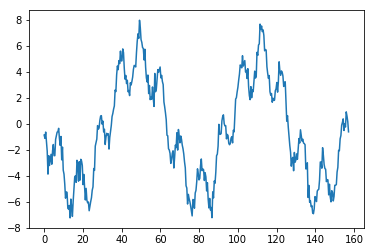

In [3]:
# example signal
plt.plot(x, signals[5]);

In [4]:
batches_in, batches_out = convert_to_batches(signals, batch_size=10)

In [5]:
tf.reset_default_graph()
network = HMLSTMNetwork(input_size=1, task='regression', hidden_state_sizes=30,
                       embed_size=50, out_hidden_size=30, num_layers=2)

In [6]:
network.train(batches_in[:-1], batches_out[:-1], epochs=1, load_vars_from_disk=True,
              save_vars_to_disk=True, variable_path='./sinusoidal')

loading variables...
INFO:tensorflow:Restoring parameters from ./sinusoidal
Epoch 0
loss: 0.53211
loss: 0.529624
loss: 0.545327
loss: 0.541836
loss: 0.559516
loss: 0.54082
loss: 0.545962
loss: 0.562599
loss: 0.549904
loss: 0.544392
loss: 0.533628
loss: 0.535238
loss: 0.555755
loss: 0.53791
loss: 0.54805
loss: 0.540646
loss: 0.554536
loss: 0.552407
loss: 0.548966
loss: 0.521315
loss: 0.525812
loss: 0.535961
loss: 0.532173
loss: 0.531217
loss: 0.506108
loss: 0.537566
loss: 0.540569
loss: 0.527848
saving variables...


In [7]:
boundaries = network.predict_boundaries(batches_in[-1])
print(boundaries)

[[[ 0.  1.  0. ...,  0.  0.  0.]
  [ 0.  1.  0. ...,  1.  1.  1.]]

 [[ 0.  0.  0. ...,  1.  1.  1.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 1.  1.  1. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 ..., 
 [[ 1.  1.  1. ...,  1.  0.  0.]
  [ 0.  0.  0. ...,  0.  1.  1.]]

 [[ 0.  0.  0. ...,  1.  1.  1.]
  [ 0.  0.  0. ...,  1.  0.  1.]]

 [[ 0.  0.  0. ...,  1.  1.  1.]
  [ 0.  0.  0. ...,  0.  0.  0.]]]


In [8]:
predictions = network.predict(batches_in[-1])

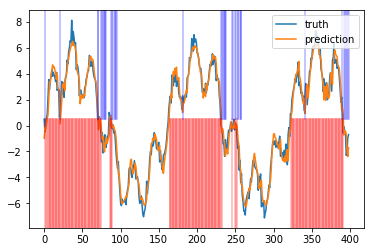

In [9]:
plot_indicators(batches_out[-1][0], predictions[0], indicators=boundaries[0]);

### Text classificaiton example

In [2]:
tf.reset_default_graph()
network = HMLSTMNetwork(output_size=27, input_size=27,
                        embed_size=2048, out_hidden_size=1024,
                        hidden_state_sizes=1024, 
                        task='classification')

In [3]:
batches_in, batches_out = prepare_inputs(batch_size=2rt, truncate_len=1000, step_size=1000,
                                         text_path='text8.txt', num_batches=3000)

In [ ]:
start = 0
end = 20

In [ ]:
while end < len(batches_in):
    network.train(batches_in[start:end], batches_out[start:end], save_vars_to_disk=True, 
                  load_vars_from_disk=True, variable_path='./text8', epochs=1)
    start = end
    end += 20

In [9]:
batch = -1

In [10]:
truth = get_text(batches_out[batch][0])
predictions = network.predict(batches_in[batch], variable_path='./text8')
boundaries = network.predict_boundaries(batches_in[batch], variable_path='./text8')
viz_char_boundaries(truth, get_text(predictions[0]), indicators=boundaries[0])

000000000000000000000000000000000000001111111111011011011000
000000000000000000000000000000000000001011000000000000000000
000000000000000000000000000000000000001000000000000000000000
aox tight tonn  m aet vies tonfreet ahen teraar tesoner tnii
six eight johnson notified congress that he had removed edwi

000000000000000000000000000000000000000000000000000000000111
000000000000000000000000000000000000000000000000000000000101
000000000000000000000000000000000000000000000000000000000100
ngt atgin al aorhesiry af ths tld tis aepoantag tis ts the c
n stanton as secretary of war and was replacing him in the i

111111111011011000000000000000000000000111111111101111111111
100000000000000000000000000000000000000101100010110101010101
000000000000000000000000000000000000000100000010000000000000
n or aatith tleocile aoner l aeng  enaheu n ahes aaeuonid th
nterim with adjutant general lorenzo thomas this violated th

111011111110110110110000000000000000000000000000000000000000
101100000000000000000